In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torchvision import datasets, models, transforms

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [7]:
import os

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join('data', x), data_transforms[x]) for x in ['train', 'val']}

In [12]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [14]:
class_names = image_datasets['train'].classes

In [15]:
class_names

['ants', 'bees']

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def imshow(im, title=None):
    im = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    im = std * im + mean
    im = np.clip(im, 0, 1)
    
    plt.imshow(im)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

In [25]:
inputs, classes = next(iter(dataloaders['train']))

In [26]:
from torchvision.utils import make_grid

In [27]:
out = make_grid(inputs)

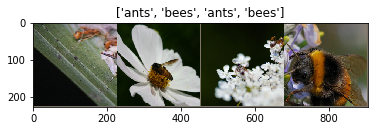

In [28]:
imshow(out, title=[class_names[x] for x in classes])

In [42]:
import time

In [48]:
def train(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs-1))
        print('-'*15)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else: 
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [94]:
def visualize(model, num_images=6):
    training = model.training
    
    model.eval()
    images = 0
    
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images += 1
                ax = plt.subplot(num_images//2, 2, images)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images == num_images:
                    model.train(mode=training)
                    return
        model.train(mode=training)

In [81]:
model = models.resnet18(pretrained=True)

In [82]:
num_features = model.fc.in_features

In [83]:
model.fc = nn.Linear(num_features, 2)

In [84]:
model = model.to(device)

In [85]:
criterion = nn.CrossEntropyLoss()

In [86]:
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [87]:
from torch.optim import lr_scheduler

In [88]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

In [89]:
import copy

In [90]:
model = train(model, criterion, optimizer, exp_lr_scheduler, epochs=35)

Epoch 0/34
---------------
train Loss: 0.7027 Acc: 0.6967
val Loss: 0.5098 Acc: 0.7908

Epoch 1/34
---------------
train Loss: 0.6357 Acc: 0.7336
val Loss: 0.6687 Acc: 0.7124

Epoch 2/34
---------------
train Loss: 0.5708 Acc: 0.7213
val Loss: 0.5720 Acc: 0.7124

Epoch 3/34
---------------
train Loss: 0.3893 Acc: 0.8238
val Loss: 0.3177 Acc: 0.8889

Epoch 4/34
---------------
train Loss: 0.4502 Acc: 0.8033
val Loss: 0.4769 Acc: 0.8170

Epoch 5/34
---------------
train Loss: 0.4527 Acc: 0.7869
val Loss: 0.3546 Acc: 0.8758

Epoch 6/34
---------------
train Loss: 0.3920 Acc: 0.8156
val Loss: 0.3107 Acc: 0.9085

Epoch 7/34
---------------
train Loss: 0.3146 Acc: 0.8770
val Loss: 0.3783 Acc: 0.8824

Epoch 8/34
---------------
train Loss: 0.2760 Acc: 0.8811
val Loss: 0.2664 Acc: 0.9150

Epoch 9/34
---------------
train Loss: 0.2665 Acc: 0.8975
val Loss: 0.3763 Acc: 0.8562

Epoch 10/34
---------------
train Loss: 0.3000 Acc: 0.8811
val Loss: 0.2806 Acc: 0.9150

Epoch 11/34
---------------
tra

In [92]:
plt.ion()

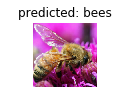

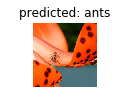

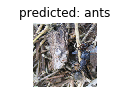

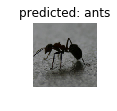

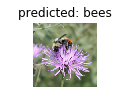

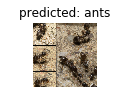

In [95]:
visualize(model)

In [109]:
model_conv = models.resnet18(pretrained=True)

In [110]:
for param in model_conv.parameters():
    param.requires_grad = False

In [111]:
num_features = model_conv.fc.in_features

In [112]:
model_conv.fc = nn.Linear(num_features, 2)

In [113]:
model_conv = model_conv.to(device)

In [115]:
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0003)

In [116]:
model_conv = train(model_conv, criterion, optimizer_conv, exp_lr_scheduler, epochs=25)

Epoch 0/24
---------------
train Loss: 0.7334 Acc: 0.5041
val Loss: 0.6134 Acc: 0.6797

Epoch 1/24
---------------
train Loss: 0.5902 Acc: 0.7377
val Loss: 0.4417 Acc: 0.8497

Epoch 2/24
---------------
train Loss: 0.5231 Acc: 0.7582
val Loss: 0.3488 Acc: 0.9150

Epoch 3/24
---------------
train Loss: 0.4583 Acc: 0.8033
val Loss: 0.2963 Acc: 0.9150

Epoch 4/24
---------------
train Loss: 0.4606 Acc: 0.8156
val Loss: 0.2803 Acc: 0.9346

Epoch 5/24
---------------
train Loss: 0.4405 Acc: 0.7910
val Loss: 0.2562 Acc: 0.9281

Epoch 6/24
---------------
train Loss: 0.4263 Acc: 0.8156
val Loss: 0.2417 Acc: 0.9346

Epoch 7/24
---------------
train Loss: 0.4152 Acc: 0.8320
val Loss: 0.2204 Acc: 0.9412

Epoch 8/24
---------------
train Loss: 0.4545 Acc: 0.7910
val Loss: 0.2259 Acc: 0.9412

Epoch 9/24
---------------
train Loss: 0.3160 Acc: 0.8852
val Loss: 0.2069 Acc: 0.9412

Epoch 10/24
---------------
train Loss: 0.3897 Acc: 0.7951
val Loss: 0.2125 Acc: 0.9477

Epoch 11/24
---------------
tra

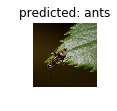

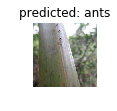

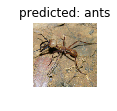

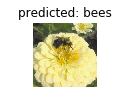

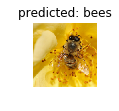

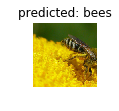

In [117]:
visualize(model_conv)
plt.ioff()
plt.show()